In [1]:
import sys
sys.path.append("..\\") # parent directory
from AQUA_general import AQUA
from batchAQUA_general import batchAQUA
from stimulus import *
from plotting_functions import *
from phase_response import *


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from functions import *

In [2]:
RS1 = {'name': 'RS', 'C': 100, 'k': 0.7, 'v_r': -60, 'v_t': -40, 'v_peak': 35,
    'a': 0.03, 'b': 40, 'c': -50, 'd': 100, 'e': 0., 'f': 0.0, 'tau': 0.0}

RS2 = {'name': 'RS', 'C': 100, 'k': 0.7, 'v_r': -60, 'v_t': -40, 'v_peak': 35,
    'a': 0.03, 'b': 40, 'c': -50, 'd': 100, 'e': 0.3, 'f': 200.0, 'tau': 0.0}

#FS1 = {'name': 'FS1', 'C': 20, 'k': 1, 'v_r': -55, 'v_t': -40, 'v_peak': 25,
#     'a': 0.2, 'b': -2, 'c': -45, 'd': 0, 'e': 0.0, 'f': 0.0, 'tau': 0.0}

#FS2 = {'name': 'FS2', 'C': 20, 'k': 1, 'v_r': -55, 'v_t': -40, 'v_peak': 25,
#     'a': 0.2, 'b': -2, 'c': -45, 'd': 0, 'e': 0.2, 'f': 200.0, 'tau': 0.0}

In [3]:
T = 2
dt = 0.01
N_iter = int(1000*T/dt)
print(N_iter)

# number of neurons
N_freq = 600
N_neurons = 6

# frequencies to sample
f_range = np.linspace(1, 200, N_freq)

threshold, x_ini = find_threshold(RS1, np.linspace(50, 400, 50), T, dt)

# Setup batch of neurons
param_arr = [RS1, RS1, RS1, RS2, RS2, RS2]

# Setup current pulses
N_pulses = 2
delay = 500 # ms
pulse_duration = 5  # ms
pulse1_end = delay + pulse_duration - dt # ms, from settings above

# minimum pulse height and the time between the end of the pulse and the spike.
pulse_height, time_to_spike = find_pulse_height(RS1, np.linspace(100, 1000, 100), threshold, x_ini, pulse_duration)  # pA
# describe ISI range relative to the time since the spike
ISI_range = np.linspace(time_to_spike + 5, 500, N_freq)

print(ISI_range)
I_inj = np.array([spikes_constant(N_iter, dt, threshold, isi, N_pulses, pulse_height, pulse_duration, delay) for isi in ISI_range for n in range(N_neurons)])
N_sims = np.shape(I_inj)[0]


200000


100%|██████████| 49999/49999 [00:09<00:00, 5057.84it/s]


[[ 19.36      ]
 [ 20.16240401]
 [ 20.96480801]
 [ 21.76721202]
 [ 22.56961603]
 [ 23.37202003]
 [ 24.17442404]
 [ 24.97682805]
 [ 25.77923205]
 [ 26.58163606]
 [ 27.38404007]
 [ 28.18644407]
 [ 28.98884808]
 [ 29.79125209]
 [ 30.59365609]
 [ 31.3960601 ]
 [ 32.19846411]
 [ 33.00086811]
 [ 33.80327212]
 [ 34.60567613]
 [ 35.40808013]
 [ 36.21048414]
 [ 37.01288815]
 [ 37.81529215]
 [ 38.61769616]
 [ 39.42010017]
 [ 40.22250417]
 [ 41.02490818]
 [ 41.82731219]
 [ 42.62971619]
 [ 43.4321202 ]
 [ 44.23452421]
 [ 45.03692821]
 [ 45.83933222]
 [ 46.64173623]
 [ 47.44414023]
 [ 48.24654424]
 [ 49.04894825]
 [ 49.85135225]
 [ 50.65375626]
 [ 51.45616027]
 [ 52.25856427]
 [ 53.06096828]
 [ 53.86337229]
 [ 54.66577629]
 [ 55.4681803 ]
 [ 56.27058431]
 [ 57.07298831]
 [ 57.87539232]
 [ 58.67779633]
 [ 59.48020033]
 [ 60.28260434]
 [ 61.08500835]
 [ 61.88741235]
 [ 62.68981636]
 [ 63.49222037]
 [ 64.29462437]
 [ 65.09702838]
 [ 65.89943239]
 [ 66.70183639]
 [ 67.5042404 ]
 [ 68.30664441]
 [ 69.10

In [4]:
# define batch now that we know how many simulations are run
batch_params = []
for i in range(N_freq):
    batch_params += param_arr
print(len(batch_params))
x_start = np.full((N_sims, 3), fill_value = x_ini)
t_start = np.zeros(N_sims)
# define and initialize
batch = batchAQUA(batch_params)
batch.Initialise(x_start, t_start)

# Run simulation
X, T, spikes = batch.update_batch(dt, N_iter, I_inj)

3600


100%|██████████| 199999/199999 [04:52<00:00, 683.16it/s]


In [5]:
pulse2_start = np.zeros(N_sims)
spike_boolean = np.zeros(N_sims)

for n in range(N_sims):
    if len(spikes[n, np.isnan(spikes[n])]) != 1:        # if 2 spikes generated
        spike_boolean[n] = 1
    pulse_times = np.argwhere(I_inj[n, :] >= threshold + 1) * dt  # pulse times in ms
    pulse2_start[n] = pulse_times[np.where(pulse_times > pulse1_end)][0] # start time of the second pulse, ms

InterPulse_Intervals = pulse2_start - pulse1_end
first_spike_time = pulse1_end + time_to_spike

resonant_ISI = np.reshape(pulse2_start - first_spike_time, shape = (N_neurons, N_freq), order = 'F')
resonant_f = 1000/resonant_ISI

print(np.shape(resonant_ISI))
print(np.shape(resonant_f))

# resonant_ISI only stores the pulse times relative to the first spike.

bands = np.reshape(spike_boolean, shape = (N_neurons, N_freq), order = 'F')

print(np.shape(bands))

resonance_bands_base_neuron = get_resonance_bands(resonant_f[0, :], bands[0, :])
print(resonance_bands_base_neuron)
largest_band_idx = np.argmax(np.diff(resonance_bands_base_neuron, axis = 1))
print(resonance_bands_base_neuron[largest_band_idx])

print(np.mean(resonance_bands_base_neuron[largest_band_idx]))

#plt.plot(resonant_f[0], bands[0], label = param_arr[0]['name'])
#plt.plot(resonant_f[1], bands[1], label = param_arr[1]['name'])
#plt.xlim((0, 100))
#plt.legend()
#plt.show()



(6, 600)
(6, 600)
(6, 600)
[[29.6647879  14.66060695]
 [12.46105919  0.        ]]
[12.46105919  0.        ]
6.2305295950174475


In [6]:
def plot_resonance_map(frequencies, bands):
    """
    Returns a heat map of the resonance frequencies of the neurons

    IN:
        frequencies:    array (N_neurons, N_frequencies)
                        list of frequencies tested

        bands:          ndarray (N_neurons, N_frequencies)
                        resonance bands for each neuron
    
    """

    fig, ax = plt.subplots(1, 1, figsize = (8, 8))

    ax.imshow(bands, origin = 'lower', cmap = 'Greys')

    ax.set_xlabel('Frequency (Hz)', fontsize = 16)
    ax.set_ylabel('Neuron index', fontsize = 16)

    ax.set_title('Resonance Map of neurons', fontsize = 20)

    return fig, ax

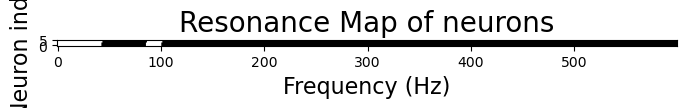

In [7]:
fig, ax = plot_resonance_map(resonant_f, bands)
plt.show()